## Evaluation report on flu hosp forecasting
Date: March 30

Elaborated by: Gautham, Srikar, Harsha, Alex

First we compare against other models submitting to CDC, then we compare against Camul.

### Overall results, comparison against CDC models
We look into summary metrics over all regions and the entire forecast horizon (weeks ahead). 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df_point = pd.read_csv('./results/march28/point_scores.csv',index_col=0)
df_spread = pd.read_csv('./results/march28/spread_scores.csv',index_col=0)
df = df_point.set_index(['Model', 'Weeks ahead','Location']).join(df_spread.set_index(['Model', 'Weeks ahead','Location']),how='left')
# make LS positive
df['LS'] = -1*df['LS']

In /home/alex/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/alex/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/alex/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/alex/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/alex/miniconda3/env

/home/alex/miniconda3/envs/py3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1373: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  return ax.bar(x, y, w, bottom=start, log=log, **kwds)


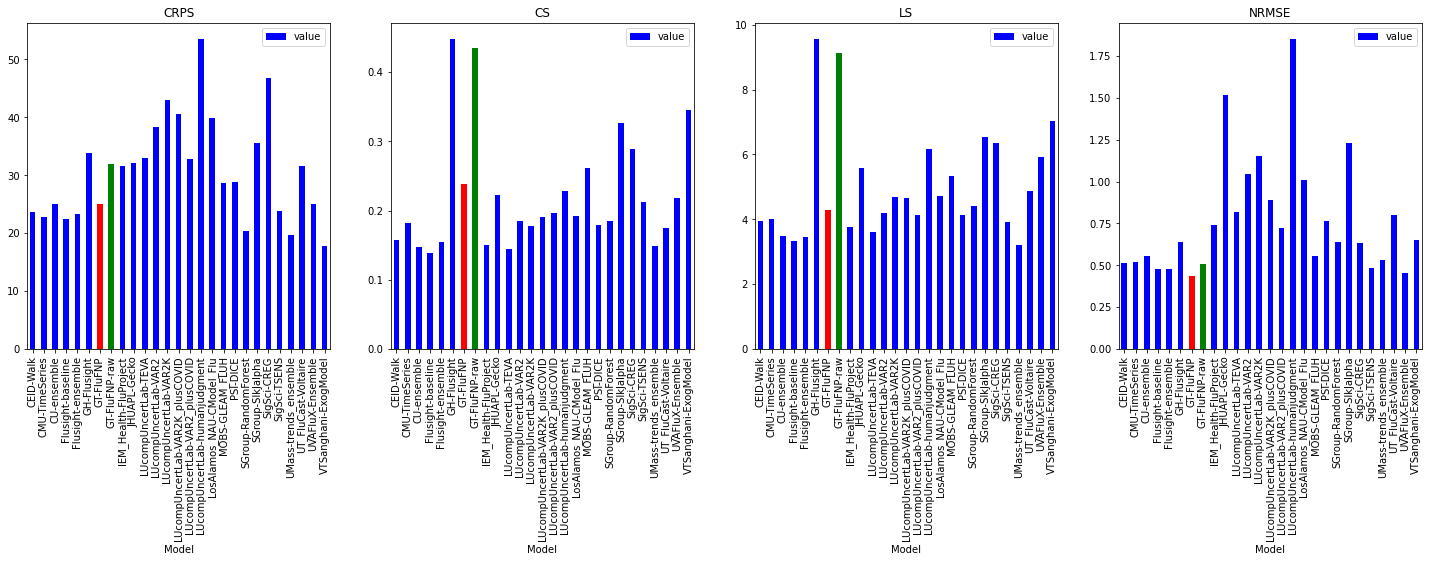

In [2]:
def plot_boxplots(dfi):
    # dfi = avg_per_model_per_week
    dfi = dfi.groupby(['Model']).mean().reset_index()
    # plot
    dfi = dfi.melt(id_vars=['Model'], value_vars=['NRMSE','CRPS','LS','CS'])
    dfi.set_index('variable',inplace=True)
    grouped = dfi.groupby(level='variable')
    my_colors = 'bbbbbbrgbbbbbbbbbbbbbbbbbb'
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25,6), sharey=False,squeeze=False)
    for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
        barlist = grouped.get_group(key).plot(ax=ax,kind='bar',x='Model',title=key,sort_columns=True,fontsize=10,color=my_colors)
    ax.legend()
    plt.show()
    
overall_avg_per_model = df.groupby(['Model']).mean()
plot_boxplots(overall_avg_per_model)


**GT-FluFNP-raw (green)** is the raw predictions. **GT-FluFNP (red)** is our submitted model, which smooths the raw predictions and uses std of data for uncertainty bounds, and some minor manual fixes. There are 27 models evaluated.

For all metrics, lower is better. CRPS, LS measures accuracy and uncertainty. CS mostly uncertainty. NRMSE only accuracy.
- CRPS: GT-FluFNP is doing well (ranked 7th out of 27 evaluated). 
- CS: Calibration score. We are among the worst. Raw predictions are even worse.
- LS: GT-FluFNP is doing well (ranked 7th)
- NRMSE: GT-FluFNP is best model. GT-FluFNP-raw is second best.

Conclusions:
- Accuracy: Our raw predictions are accurate. Smoothing is helping to improve accuracy.
- Uncertainty: Our raw uncertainty bounds are very bad (overconfidence). Our current process to add uncertainty bounds is helping but it is not good enough. 

In [3]:
avg_per_model_per_week = df.groupby(['Model','Weeks ahead']).mean()
avg_per_model_per_week = avg_per_model_per_week.reset_index()

#### Analyze 1-2 week ahead forecasting

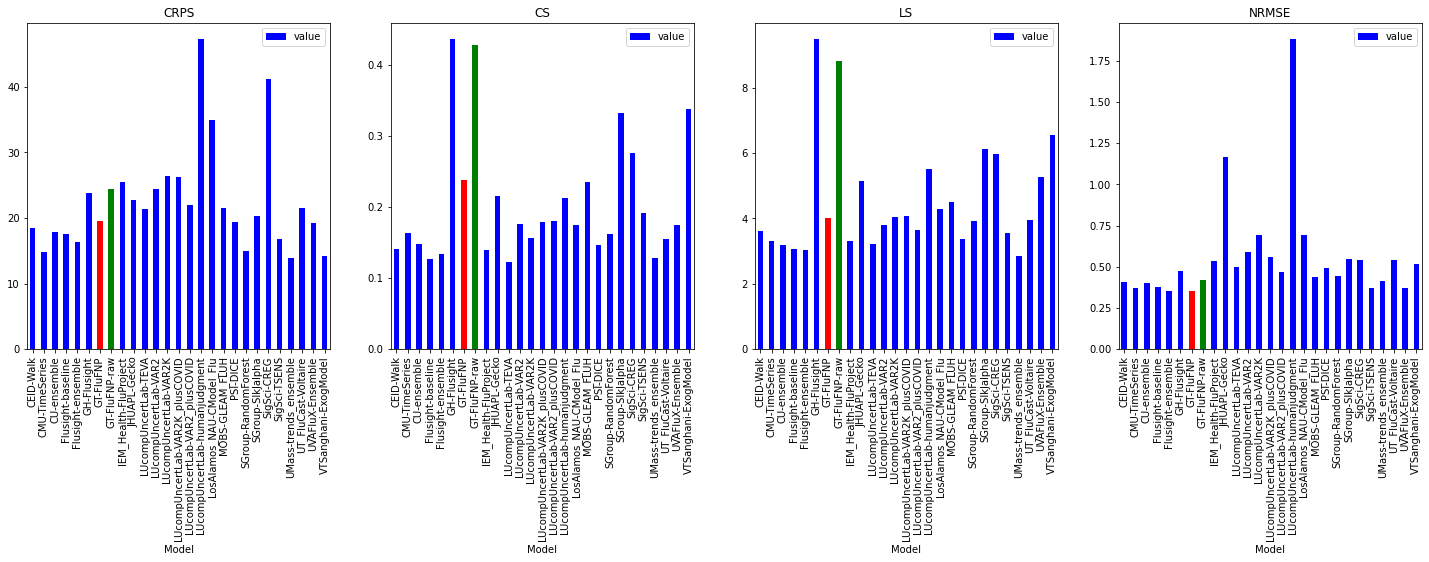

In [4]:
dfi = avg_per_model_per_week
dfi = dfi[dfi['Weeks ahead'].isin([1,2])].drop(['Weeks ahead'],axis=1)
plot_boxplots(dfi)

#### Analyze 3-4 week ahead forecasting

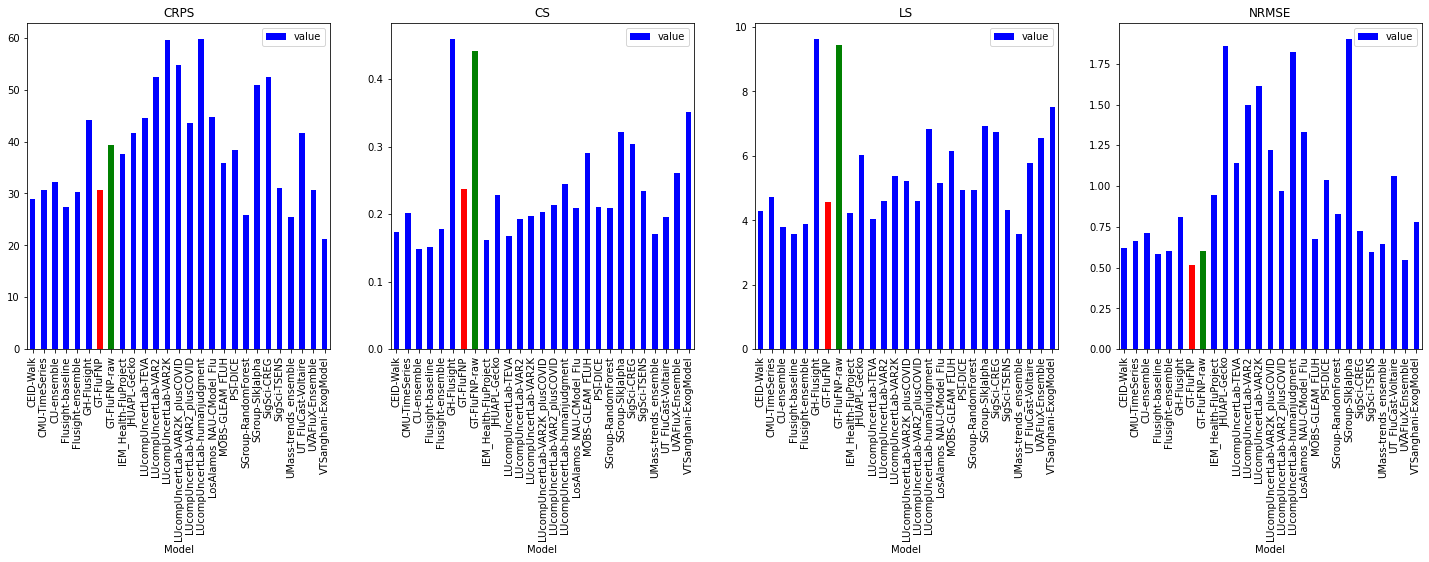

In [5]:
dfi = avg_per_model_per_week
dfi = dfi[dfi['Weeks ahead'].isin([3,4])].drop(['Weeks ahead'],axis=1)
plot_boxplots(dfi)

We don't see any different patterns. Conclusions remain the same.

### Comparison against Camul


In [19]:
%precision 4
processed = overall_avg_per_model.loc['GT-FluFNP']
raw = overall_avg_per_model.loc['GT-FluFNP-raw']
print('======== CRPS ========')
print('GT-FluFNP', processed['CRPS'])
print('GT-FluFNP-raw', raw['CRPS'])

======== CRPS ========
GT-FluFNP 25.0984137836804
GT-FluFNP-raw 31.902349371214246


Camul's CRPS for covid19 is 27.3. We are in the same ballpark.

In [20]:
print('======== CS ========')
print('GT-FluFNP', processed['CS'])
print('GT-FluFNP-raw', raw['CS'])

======== CS ========
GT-FluFNP 0.23785533960061345
GT-FluFNP-raw 0.4346474984982434


Camul's CS for covid19 is 0.14. The raw predictions have bad CS. We have to investigate this further.

In [22]:
print('======== NRMSE ========')
print('GT-FluFNP', processed['RMSE'])
print('GT-FluFNP-raw', raw['RMSE'])

======== NRMSE ========
GT-FluFNP 37.96700679360358
GT-FluFNP-raw 40.714919069840725


Camul's NRMSE for covid19 is 27.3. We are higher than this.

Conclusion:
- Camul did much better in uncertainty quantification for covid19. We need further investigation.